# Facial Emotion Recognition using CNNs

## Imports

In [3]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from random import randint
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau


# import matplotlib.image as mpimg

from keras.preprocessing.image import load_img,ImageDataGenerator
from keras.utils import plot_model


## Exploratory Data Analysis

In [4]:
train_file_count = {}
path, dirs, files = next(os.walk("/content/train/angry"))
train_file_count['angry'] = len(files)
path, dirs, files = next(os.walk("/content/train/disgust"))
train_file_count['disgust'] = len(files)
path, dirs, files = next(os.walk("/content/train/fear"))
train_file_count['fear'] = len(files)
path, dirs, files = next(os.walk("/content/train/happy"))
train_file_count['happy'] = len(files)
path, dirs, files = next(os.walk("/content/train/neutral"))
train_file_count['neutral'] = len(files)
path, dirs, files = next(os.walk("/content/train/sad"))
train_file_count['sad'] = len(files)
path, dirs, files = next(os.walk("/content/train/surprise"))
train_file_count['surprise'] = len(files)

test_file_count = {}
path, dirs, files = next(os.walk("/content/test/angry"))
test_file_count['angry'] = len(files)
path, dirs, files = next(os.walk("/content/test/disgust"))
test_file_count['disgust'] = len(files)
path, dirs, files = next(os.walk("/content/test/fear"))
test_file_count['fear'] = len(files)
path, dirs, files = next(os.walk("/content/test/happy"))
test_file_count['happy'] = len(files)
path, dirs, files = next(os.walk("/content/test/neutral"))
test_file_count['neutral'] = len(files)
path, dirs, files = next(os.walk("/content/test/sad"))
test_file_count['sad'] = len(files)
path, dirs, files = next(os.walk("/content/test/surprise"))
test_file_count['surprise'] = len(files)

In [5]:
pd.DataFrame(train_file_count.items())

,0,1
0,angry,3995
1,disgust,436
2,fear,4097
3,happy,7215
4,neutral,4965
5,sad,4830
6,surprise,3171


In [6]:
pd.DataFrame(test_file_count.items())

,0,1
0,angry,958
1,disgust,111
2,fear,1024
3,happy,1774
4,neutral,1233
5,sad,1247
6,surprise,831


In [7]:
train = []
for dirname, dirs, filenames in os.walk('/content/train', topdown=True):
    for filename in filenames:
        train.append(os.path.join(dirname, filename))
test = []
for dirname, dirs, filenames in os.walk('/content/test', topdown=True):
    for filename in filenames:
        test.append(os.path.join(dirname, filename))

In [8]:
len(train),len(test)

(28709, 7178)

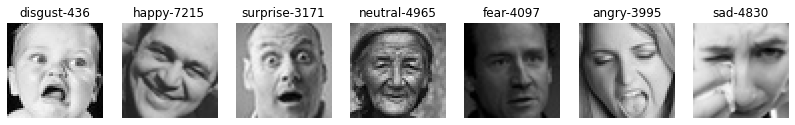

In [9]:
train_path = '/content/train/'
test_path = '/content/test/'

rand_indices = np.zeros(8)
i = 1
plt.figure(figsize=(14,22))
for expressionName in os.listdir(train_path):
    
    rand_indices[i] = train_file_count[expressionName]
    demo_image = load_img(train_path + expressionName + '/' + os.listdir(train_path + expressionName)[randint(1,rand_indices[i])])

    plt.subplot(1,7,i)
    plt.imshow(demo_image)
    plt.title(expressionName+'-'+str(round(rand_indices[i])))
    i = i + 1
    plt.axis('off')

##  Image Augmentation for better model performance

In [10]:

train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2)

training_set = train_datagen.flow_from_directory(train_path,batch_size=64,target_size = (48,48),shuffle = True,color_mode = 'grayscale',class_mode = 'categorical')



test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(test_path,batch_size=64,target_size = (48,48),shuffle = True,color_mode = 'grayscale',class_mode = 'categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
test_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## CNN Models 

In [24]:
model = tf.keras.models.Sequential()   

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape = (48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

#Compliling the model
model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
plot_model(model,show_shapes=True,show_layer_names=False)

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 22, 22, 256)      

In [27]:
log_path = "logs/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath='ExpRecModel.h5',save_best_only=True,verbose=1,mode='min',moniter='val_loss')
early_stop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1, min_delta=0.0001)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path, histogram_freq=1)
csv_logger = CSVLogger('csvLogTraining.log')

callbacks = [checkpoint,early_stop,reduce_lr,tensorboard_callback, csv_logger]

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

fitresult = model.fit(x=training_set,validation_data=test_set,epochs=120,callbacks=callbacks,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Epoch 1/120
448/448 [==============================] - 60s 59ms/step - loss: 10.4358 - accuracy: 0.2027 - val_loss: 9.5781 - val_accuracy: 0.2352

Epoch 00001: val_loss improved from inf to 9.57806, saving model to ExpRecModel.h5
Epoch 2/120
448/448 [==============================] - 24s 54ms/step - loss: 8.3763 - accuracy: 0.2395 - val_loss: 6.9428 - val_accuracy: 0.3093

Epoch 00002: val_loss improved from 9.57806 to 6.94279, saving model to ExpRecModel.h5
Epoch 3/120
448/448 [==============================] - 24s 54ms/step - loss: 6.6361 - accuracy: 0.2616 - val_loss: 5.3968 - val_accuracy: 0.3397

Epoch 00003: val_loss improved from 6.94279 to 5.39682, saving model to ExpRecModel.h5
Epoch 4/120
448/448 [==============================] - 24s 54ms/step - loss: 5.1984 - accuracy: 0.2893 - val_loss: 4.2149 - val_accuracy: 0.3842

Epoch 00004: val_loss improved from 5.39682 to 4.21488, saving model to ExpRecModel.h5
Epoch 5/120
448/448 [==============================] - 24s 54ms/step - 

In [28]:
model.evaluate(test_set)

113/113 [==============================] - 2s 20ms/step - loss: 1.0534 - accuracy: 0.6755


[1.0534309148788452, 0.6755363345146179]

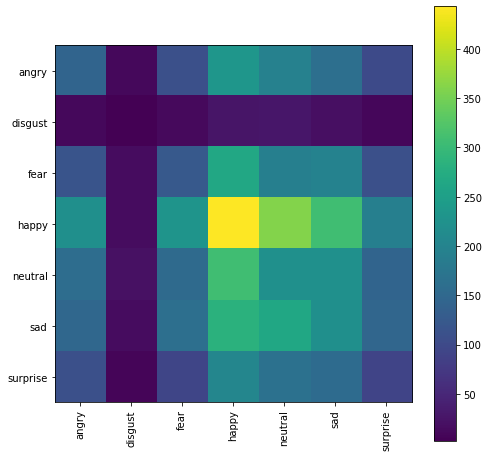

In [34]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(test_set.classes, y_pred)

target_names = list(class_labels.values())


plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
shcnn = tf.keras.models.Sequential()   

shcnn.add(Conv2D(44, kernel_size=(5, 5), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.02), input_shape = (48,48,1)))
shcnn.add(MaxPooling2D(2, 2))


shcnn.add(Conv2D(44, kernel_size=(3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.02), padding='same'))
shcnn.add(MaxPooling2D(2, 2))

shcnn.add(Conv2D(88, kernel_size=(5, 5), activation=tf.keras.layers.LeakyReLU(alpha=0.02), padding='same'))
shcnn.add(MaxPooling2D(2, 2))

shcnn.add(Flatten())

shcnn.add(Dense(2048, activation=tf.keras.layers.LeakyReLU(alpha=0.02)))
shcnn.add(Dropout(0.4))

shcnn.add(Dense(1024, activation=tf.keras.layers.LeakyReLU(alpha=0.02)))
shcnn.add(Dropout(0.4))

shcnn.add(Dense(7, activation='softmax'))

#Compliling the model
shcnn.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
log_path = "logs/tensorboard/shcnn" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath='ExpRecModelShcnn.h5',save_best_only=True,verbose=1,mode='min',moniter='val_loss')
early_stop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1, min_delta=0.0001)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path, histogram_freq=1)
csv_logger = CSVLogger('csvLogTrainingShcnn.log')

callbacks = [checkpoint,early_stop,reduce_lr,tensorboard_callback, csv_logger]

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

fitresult = shcnn.fit(x=training_set,validation_data=test_set,epochs=60,callbacks=callbacks,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Epoch 1/60
897/897 [==============================] - 21s 23ms/step - loss: 1.8099 - accuracy: 0.2548 - val_loss: 1.6002 - val_accuracy: 0.3768

Epoch 00001: val_loss improved from inf to 1.60017, saving model to ExpRecModelShcnn.h5
Epoch 2/60
897/897 [==============================] - 21s 23ms/step - loss: 1.6085 - accuracy: 0.3738 - val_loss: 1.4804 - val_accuracy: 0.4230

Epoch 00002: val_loss improved from 1.60017 to 1.48043, saving model to ExpRecModelShcnn.h5
Epoch 3/60
897/897 [==============================] - 20s 23ms/step - loss: 1.4965 - accuracy: 0.4233 - val_loss: 1.3845 - val_accuracy: 0.4681

Epoch 00003: val_loss improved from 1.48043 to 1.38449, saving model to ExpRecModelShcnn.h5
Epoch 4/60
897/897 [==============================] - 22s 24ms/step - loss: 1.4256 - accuracy: 0.4519 - val_loss: 1.3273 - val_accuracy: 0.4894

Epoch 00004: val_loss improved from 1.38449 to 1.32729, saving model to ExpRecModelShcnn.h5
Epoch 5/60
897/897 [==============================] - 21

In [ ]:
shcnn.evaluate(test_set)

225/225 [==============================] - 2s 9ms/step - loss: 1.0586 - accuracy: 0.6162


[1.0585922002792358, 0.6161883473396301]

In [21]:
pranjmodel = tf.keras.models.Sequential([
Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same',input_shape = (48,48,1)),
MaxPooling2D(2, 2),
Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'),
MaxPooling2D(2, 2),
Conv2D(128, kernel_size=(4, 4), activation='relu', padding='same'),
MaxPooling2D(2, 2),
Flatten(),
Dense(2048, activation='relu'),
Dropout(0.4),
Dense(1024, activation='relu'),
Dropout(0.4),
Dense(7, activation='softmax') ])

#Compliling the model
pranjmodel.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])


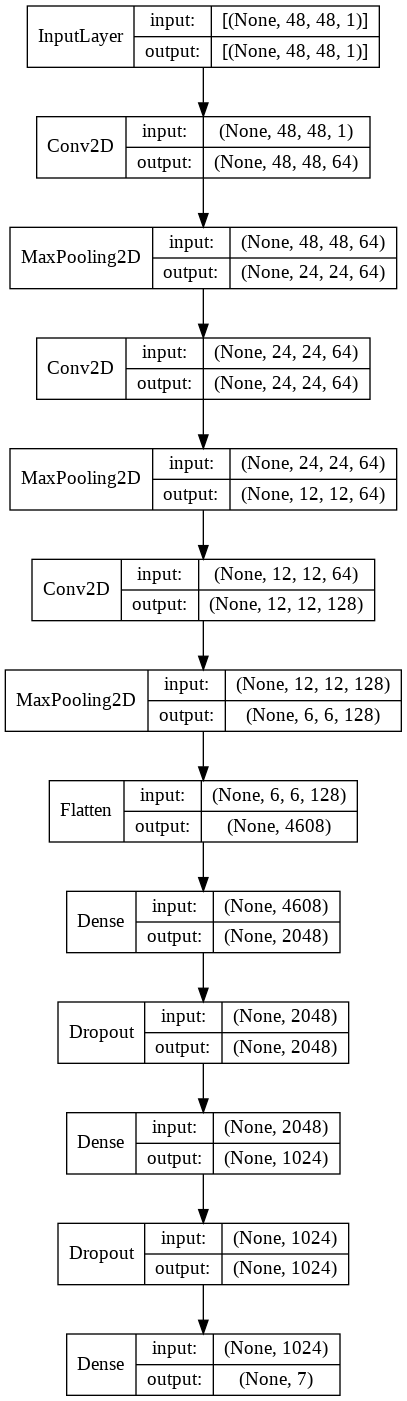

In [23]:
plot_model(pranjmodel, to_file='fernet.png', show_shapes=True, show_layer_names=False)

In [ ]:
log_path = "logs/tensorboard/pranjmodel" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath='ExpRecModelpranjmodel.h5',save_best_only=True,verbose=1,mode='min',moniter='val_loss')
early_stop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1, min_delta=0.0001)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path, histogram_freq=1)
csv_logger = CSVLogger('csvLogTrainingPranjmodel.log')

callbacks = [checkpoint,early_stop,reduce_lr,tensorboard_callback, csv_logger]

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

fitresult = pranjmodel.fit(x=training_set,validation_data=test_set,epochs=60,callbacks=callbacks,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

In [ ]:
pranjmodel.evaluate(test_set)

225/225 [==============================] - 2s 9ms/step - loss: 1.0231 - accuracy: 0.6402


[1.0230839252471924, 0.6401504874229431]

In [ ]:
alexmodel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), activation='relu', input_shape=(48,48,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

alexmodel.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
log_path = "logs/tensorboard/alex" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath='ExpRecModelAlex.h5',save_best_only=True,verbose=1,mode='min',moniter='val_loss')
early_stop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1, min_delta=0.0001)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path, histogram_freq=1)
csv_logger = CSVLogger('csvLogTrainingAlex.log')

callbacks = [checkpoint,early_stop,reduce_lr,tensorboard_callback, csv_logger]

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

fitresult = alexmodel.fit(x=training_set,validation_data=test_set,epochs=100,callbacks=callbacks,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Epoch 1/100
448/448 [==============================] - 24s 50ms/step - loss: 1.9422 - accuracy: 0.2478 - val_loss: 1.8917 - val_accuracy: 0.2616

Epoch 00001: val_loss improved from inf to 1.89166, saving model to ExpRecModelAlex.h5
Epoch 2/100
448/448 [==============================] - 21s 47ms/step - loss: 1.6071 - accuracy: 0.3714 - val_loss: 1.7177 - val_accuracy: 0.2891

Epoch 00002: val_loss improved from 1.89166 to 1.71768, saving model to ExpRecModelAlex.h5
Epoch 3/100
448/448 [==============================] - 21s 47ms/step - loss: 1.5129 - accuracy: 0.4158 - val_loss: 1.5207 - val_accuracy: 0.4056

Epoch 00003: val_loss improved from 1.71768 to 1.52070, saving model to ExpRecModelAlex.h5
Epoch 4/100
448/448 [==============================] - 22s 49ms/step - loss: 1.4313 - accuracy: 0.4438 - val_loss: 1.4055 - val_accuracy: 0.4591

Epoch 00004: val_loss improved from 1.52070 to 1.40547, saving model to ExpRecModelAlex.h5
Epoch 5/100
448/448 [==============================] - 2

In [ ]:
alexmodel.evaluate(test_set)

113/113 [==============================] - 2s 19ms/step - loss: 1.0572 - accuracy: 0.6255


[1.0572038888931274, 0.6255224347114563]

In [76]:
vggmodel = tf.keras.models.Sequential()
vggmodel.add(tf.keras.layers.Conv2D(input_shape=(48,48,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
vggmodel.add(tf.keras.layers.Dropout(0.2))

vggmodel.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
vggmodel.add(tf.keras.layers.Dropout(0.3))

vggmodel.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
vggmodel.add(tf.keras.layers.Dropout(0.4))

vggmodel.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
vggmodel.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggmodel.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
vggmodel.add(tf.keras.layers.Dropout(0.5))


vggmodel.add(tf.keras.layers.Flatten())
vggmodel.add(tf.keras.layers.Dense(units=4096,activation="relu"))
vggmodel.add(tf.keras.layers.Dropout(0.5))
vggmodel.add(tf.keras.layers.Dense(units=4096,activation="relu"))
vggmodel.add(tf.keras.layers.Dropout(0.5))

vggmodel.add(tf.keras.layers.Dense(units=7, activation="softmax"))

#0vggmodel.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
vggmodel.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])


log_path = "logs/tensorboard/vgg" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


checkpoint = ModelCheckpoint(filepath='ExpRecModelVGG.h5',save_best_only=True,verbose=1,mode='min',moniter='val_loss')
early_stop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1, min_delta=0.0001)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path, histogram_freq=1)
csv_logger = CSVLogger('csvLogTrainingVGG.log')

callbacks = [checkpoint,early_stop,reduce_lr,tensorboard_callback, csv_logger]

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

fitresult = vggmodel.fit(x=training_set,validation_data=test_set,epochs=100,callbacks=callbacks,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Epoch 1/100
448/448 [==============================] - 34s 74ms/step - loss: 1.8334 - accuracy: 0.2431 - val_loss: 1.8158 - val_accuracy: 0.2473

Epoch 00001: val_loss improved from inf to 1.81578, saving model to ExpRecModelVGG.h5
Epoch 2/100
448/448 [==============================] - 32s 72ms/step - loss: 1.8151 - accuracy: 0.2487 - val_loss: 1.8114 - val_accuracy: 0.2471

Epoch 00002: val_loss improved from 1.81578 to 1.81135, saving model to ExpRecModelVGG.h5
Epoch 3/100
448/448 [==============================] - 32s 72ms/step - loss: 1.8054 - accuracy: 0.2542 - val_loss: 1.7765 - val_accuracy: 0.2641

Epoch 00003: val_loss improved from 1.81135 to 1.77647, saving model to ExpRecModelVGG.h5
Epoch 4/100
448/448 [==============================] - 32s 72ms/step - loss: 1.7575 - accuracy: 0.2744 - val_loss: 1.6449 - val_accuracy: 0.3488

Epoch 00004: val_loss improved from 1.77647 to 1.64491, saving model to ExpRecModelVGG.h5
Epoch 5/100
448/448 [==============================] - 33s 7

In [77]:
vggmodel.evaluate(test_set)

113/113 [==============================] - 3s 24ms/step - loss: 0.9446 - accuracy: 0.6617


[0.9446181654930115, 0.661744236946106]